In [47]:
import pandas as pd
import numpy as np

In [48]:
train = pd.read_csv('dataset csv\\test_QaJU1Mh.csv')
train.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural


In [49]:
train.dtypes

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
dtype: object

In [50]:
train.isnull().sum(axis=1).sum()

1416

In [51]:
train = train.dropna()

In [52]:
for col in train.columns:
    print(col)
    print(train[col].describe())
    print()

id
count     32895.000000
mean      56736.851497
std       32944.071851
min           1.000000
25%       28217.000000
50%       56476.000000
75%       85414.000000
max      114077.000000
Name: id, dtype: float64

perc_premium_paid_by_cash_credit
count    32895.000000
mean         0.315435
std          0.329106
min          0.000000
25%          0.039000
50%          0.176000
75%          0.537000
max          1.000000
Name: perc_premium_paid_by_cash_credit, dtype: float64

age_in_days
count    32895.000000
mean     18778.398146
std       5134.344697
min       7671.000000
25%      14973.000000
50%      18622.000000
75%      22279.000000
max      35785.000000
Name: age_in_days, dtype: float64

Income
count    3.289500e+04
mean     2.028720e+05
std      2.261669e+05
min      2.403000e+04
25%      1.081100e+05
50%      1.659300e+05
75%      2.501000e+05
max      2.191455e+07
Name: Income, dtype: float64

Count_3-6_months_late
count    32895.000000
mean         0.245022
std          0.69404

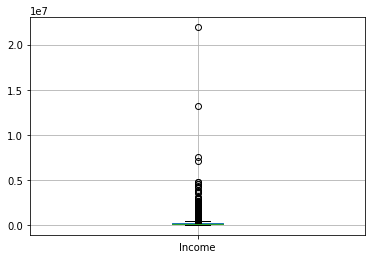

In [53]:
import matplotlib.pyplot as plt
plt.figure()
train.boxplot(column=['Income'])
plt.show()

In [54]:
train.drop(train[train['Income'] >= 452000].index, inplace=True)
print(train.shape)
print(train['Income'].describe())

(31505, 11)
count     31505.000000
mean     179087.973655
std       94253.108940
min       24030.000000
25%      105140.000000
50%      161930.000000
75%      238910.000000
max      451850.000000
Name: Income, dtype: float64


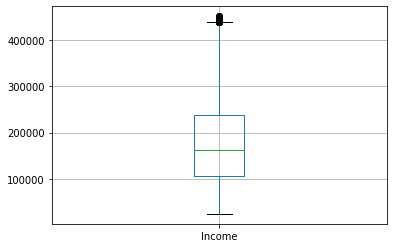

In [55]:
plt.figure()
train.boxplot(column=['Income'])
plt.show()

In [56]:
from sklearn.preprocessing import LabelEncoder
newtrain = dict()
for key in train.keys():
    if train[key].dtypes == 'object':
        le = LabelEncoder()
        le.fit(train[key])
        newtrain[key] = le.transform(train[key])
    else:
        newtrain[key] = train[key]

res = pd.DataFrame.from_dict(newtrain, orient='columns', dtype=None)

In [57]:
from sklearn.model_selection import train_test_split


X = res.iloc[:, :-1]
y = res.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [58]:
from collections import Counter
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_new_train, y_train = oversample.fit_resample(X_train, y_train)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier

gnb = GaussianNB()
logreg = LogisticRegression(solver="lbfgs")
kneig = KNeighborsClassifier(3)
randfor = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
dectree = DecisionTreeClassifier(max_depth=5)

ensemble_classifier = VotingClassifier(
    estimators=[('gnb', gnb), ('logreg', logreg), ('kneig', kneig), ("randfor", randfor), ("dectree", dectree)],
    voting='hard'
)

# Fit the ensemble regressor
ensemble_classifier.fit(X_new_train, y_train)

# Predict with the ensemble regressor
y_pred = ensemble_classifier.predict(X_test)


c:\Users\guido\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\guido\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

def metrics_scores(clf):
    print(accuracy_score(y_test, y_pred))
    print("Accuracy: %0.2f" % accuracy_score(y_test, y_pred))
    pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=1)
    print(clf, ': Accuracy score: ', round(accuracy_score(y_test, y_pred), 4), "Precision",
                round(pr, 4), ' Recall ', round(rc, 4), ' FScore ', round(fs, 4))
    cmatrix = confusion_matrix(y_test, y_pred)
    print(cmatrix)
    report = classification_report(y_pred, y_test, zero_division=1)
    print(report)
    print()

In [61]:
classifiers = ensemble_classifier.named_estimators_

# Print the individual classifiers
for name, classifier in classifiers.items():
    print(f"Classifier Name: {name}")
    metrics_scores(classifier)
    print("---------------------------------")

Classifier Name: gnb
0.48317816335167163
Accuracy: 0.48
GaussianNB() : Accuracy score:  0.4832 Precision 0.4947  Recall  0.4945  FScore  0.4816
[[2026 1679]
 [3206 2541]]
              precision    recall  f1-score   support

           0       0.55      0.39      0.45      5232
           1       0.44      0.60      0.51      4220

    accuracy                           0.48      9452
   macro avg       0.49      0.49      0.48      9452
weighted avg       0.50      0.48      0.48      9452


---------------------------------
Classifier Name: logreg
0.48317816335167163
Accuracy: 0.48
LogisticRegression() : Accuracy score:  0.4832 Precision 0.4947  Recall  0.4945  FScore  0.4816
[[2026 1679]
 [3206 2541]]
              precision    recall  f1-score   support

           0       0.55      0.39      0.45      5232
           1       0.44      0.60      0.51      4220

    accuracy                           0.48      9452
   macro avg       0.49      0.49      0.48      9452
weighted avg 

In [62]:
metrics_scores(ensemble_classifier)

0.48317816335167163
Accuracy: 0.48
VotingClassifier(estimators=[('gnb', GaussianNB()),
                             ('logreg', LogisticRegression()),
                             ('kneig', KNeighborsClassifier(n_neighbors=3)),
                             ('randfor',
                              RandomForestClassifier(max_depth=5,
                                                     max_features=1,
                                                     n_estimators=10)),
                             ('dectree', DecisionTreeClassifier(max_depth=5))]) : Accuracy score:  0.4832 Precision 0.4947  Recall  0.4945  FScore  0.4816
[[2026 1679]
 [3206 2541]]
              precision    recall  f1-score   support

           0       0.55      0.39      0.45      5232
           1       0.44      0.60      0.51      4220

    accuracy                           0.48      9452
   macro avg       0.49      0.49      0.48      9452
weighted avg       0.50      0.48      0.48      9452




In [67]:
from sklearn.model_selection import KFold, cross_validate

def k_folds(clf):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scoring = ['accuracy', 'precision', 'recall']
    results = cross_validate(clf,X,y,scoring=scoring,cv=cv, n_jobs=-1)
    print("Accuracy: {:.4f}".format(results['test_accuracy'].mean()))
    print("Recall: {:.4f}".format(results['test_recall'].mean()))
    print("Precision: {:.4f}".format(results['test_precision'].mean()))

In [68]:
classifiers = ensemble_classifier.named_estimators_

# Print the individual classifiers
for name, classifier in classifiers.items():
    print(f"Classifier Name: {name}")
    k_folds(classifier)
    print("---------------------------------")

Classifier Name: gnb
Accuracy: 0.6027
Recall: 0.9997
Precision: 0.6028
---------------------------------
Classifier Name: logreg
Accuracy: 0.6029
Recall: 1.0000
Precision: 0.6029
---------------------------------
Classifier Name: kneig
Accuracy: 0.5280
Recall: 0.6546
Precision: 0.5994
---------------------------------
Classifier Name: randfor
Accuracy: 0.6028
Recall: 0.9995
Precision: 0.6029
---------------------------------
Classifier Name: dectree
Accuracy: 0.5996
Recall: 0.9884
Precision: 0.6023
---------------------------------


In [69]:
k_folds(ensemble_classifier)

Accuracy: 0.6029
Recall: 1.0000
Precision: 0.6029
